# Prediciton of number of Flight passengers

In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

The seaborn library comes with some data sets.<br>
Let's check which datasets it comes with (the names).

In [2]:
sns.get_dataset_names()

['anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

We'll be working with the `flights` dataset.<br>
This is a dataset containinng 144 rows and 3 columns. The columns are `year`, `month` and `passengers` (number of passengers). <br>
This means that the dataset contains passenger per month information for a span of 12 years.

In [3]:
flight_data = sns.load_dataset('flights')
flight_data.shape

(144, 3)

In [4]:
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


Let's look at a statistical description of the data set.

In [5]:
flight_data.describe()

,year,passengers
count,144.000000,144.000000
mean,1954.500000,280.298611
std,3.464102,119.966317
min,1949.000000,104.000000
25%,1951.750000,180.000000
50%,1954.500000,265.500000
75%,1957.250000,360.500000
max,1960.000000,622.000000


It can clearly be seeing that the number of passengers increased over the years going way beyond the double of passenger numbers at the end.

In [6]:
# check the type of the information on the columns
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [7]:
pass_column_float = flight_data['passengers'].values.astype(float)
pass_column_float

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

We need to split the data in training and validation data now before we normalized the data.<br>
The reason why we don't want to normalize the data is because by normalizing the validation data there would be a chance that some information would be leaked from the training set into the test set.<br>
We'll keep the last 12 months of the data set as validation set.

In [8]:
validation_dataset_size = 12
train_set = pass_column_float[:-validation_dataset_size]
validation_set = pass_column_float[-validation_dataset_size:]

We need to normalize the training dataset - when working with time series datasets it's better to normalize the dataset. Otherwise we will not get much form the lstm algorithm.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_set_norm = scaler.fit_transform(train_set .reshape(-1, 1))
print(train_set_norm[:5])
print(train_set_norm[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


Convert the dataset into tensors

In [10]:
train_set_norm = torch.FloatTensor(train_set_norm).view(-1)

Create a function that returns a list of tupples. Each tupple will have 2 elements. The first element will be a list of 12 numbers, each of which will be the number of passengers in a month. The second element will be the number of passengers in the 12+1th month.

In [11]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [12]:
train_inout_seq = create_inout_sequences(train_set_norm, 12) # I am defining a train window of 12 months

In [13]:
len(train_inout_seq)

120

In [14]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

Creating the LSTM model

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_layer=1, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layer = num_layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq, hidden_cell):
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1], hidden_cell

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        hidden = (weight.new(self.num_layer, batch_size, self.hidden_layer_size).zero_(),
                  weight.new(self.num_layer, batch_size, self.hidden_layer_size).zero_())

        return hidden

In [16]:
model = LSTM(hidden_layer_size=15)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
print(model)

LSTM(
  (lstm): LSTM(1, 15)
  (linear): Linear(in_features=15, out_features=1, bias=True)
)


In [18]:
h = model.init_hidden(1) # batch_size is always 1 for this exercies
epochs = 150

model.train()
for i in range(epochs):
    for seq, labels in train_inout_seq:
        h = tuple([each.data for each in h])
        optimizer.zero_grad()
        
        y_pred, h = model(seq, h)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 ==1:
        print(f'    epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00900803
    epoch:  26 loss: 0.02999244
    epoch:  51 loss: 0.00122716
    epoch:  76 loss: 0.00197563
    epoch: 101 loss: 0.00191304
    epoch: 126 loss: 0.00000045
epoch: 149 loss: 0.0001128420


Now that our model is trained, we can start to make predictions. Since our test set contains the passenger data for the last 12 months and our model is trained to make predictions using a sequence length of 12. We will first filter the last 12 values from the training set

In [19]:
fut_pred = 12

test_inputs = train_set_norm[-fut_pred:].tolist()
test_inputs

[0.12527473270893097,
 0.04615384712815285,
 0.3274725377559662,
 0.2835164964199066,
 0.3890109956264496,
 0.6175824403762817,
 0.9516483545303345,
 1.0,
 0.5780220031738281,
 0.33186814188957214,
 0.13406594097614288,
 0.32307693362236023]

In [20]:
torch.FloatTensor(test_inputs[-12:])

tensor([0.1253, 0.0462, 0.3275, 0.2835, 0.3890, 0.6176, 0.9516, 1.0000, 0.5780,
        0.3319, 0.1341, 0.3231])

In [21]:
h = model.init_hidden(1)
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-12:])
    with torch.no_grad():
        h = tuple([each.data for each in h])
        output, h = model(seq, h)
        test_inputs.append(output.item())

test_inputs[fut_pred:]

[0.3781741261482239,
 0.3932289779186249,
 0.45607978105545044,
 0.5297241806983948,
 0.6331286430358887,
 0.7657564878463745,
 0.9349579215049744,
 1.1015832424163818,
 1.0096887350082397,
 0.8236794471740723,
 0.6185077428817749,
 0.5021070837974548]

In [22]:
final_prediction = scaler.inverse_transform(np.array(test_inputs[fut_pred:]).reshape(-1,1))
final_prediction

array([[417.5346137 ],
       [420.95959248],
       [435.25815019],
       [452.01225111],
       [475.53676629],
       [505.70960099],
       [544.20292714],
       [582.11018765],
       [561.20418721],
       [518.88707423],
       [472.21051151],
       [445.72936156]])

Ploting the predictions on top of our ground truth

[132 133 134 135 136 137 138 139 140 141 142 143]


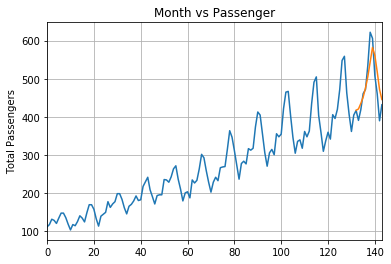

In [23]:
x = np.arange(132, 144, 1)
print(x)

plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,final_prediction)
plt.show()